In [2]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Read Data
df = pd.read_csv('aapl_ok.csv',sep=';')
df['fecha'] = pd.to_datetime(df['fecha'],format="%m/%d/%Y")
df['Ingresos'] = df['Ingresos'].str.replace(',', '.').astype(float)
df = df.set_index('fecha')
df.head()

,Trimeste,Ingresos
fecha,,
1989-12-29,Q1 1990,1493.4
1990-03-30,Q2 1990,1346.2
1990-06-29,Q3 1990,1364.8
1990-09-28,Q4 1990,1354.1
1990-12-28,Q1 1991,1675.5


In [4]:
from sktime.forecasting.model_selection import temporal_train_test_split

In [5]:
y_train, y_test = temporal_train_test_split(y = df['Ingresos'].astype('float64').to_period('Q'), test_size=8)

# ETS

In [6]:
from sktime.forecasting.ets import AutoETS

In [7]:
ets_model = AutoETS(auto=True, sp=4, n_jobs=-1)
ets_model.fit(y_train)
print(ets_model.summary())

                                 ETS Results                                  
Dep. Variable:               Ingresos   No. Observations:                  119
Model:                       ETS(MAM)   Log Likelihood                -968.025
Date:                Mon, 09 Oct 2023   AIC                           1956.050
Time:                        00:26:42   BIC                           1983.841
Sample:                    12-31-1989   HQIC                          1967.335
                         - 06-30-2019   Scale                            0.018
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.4225      0.055      7.739      0.000       0.316       0.530
smoothing_trend        0.1685      0.034      4.890      0.000       0.101       0.236
smoothing_seasonal  

In [8]:
from sktime.utils.plotting import plot_series

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Ingresos'>)

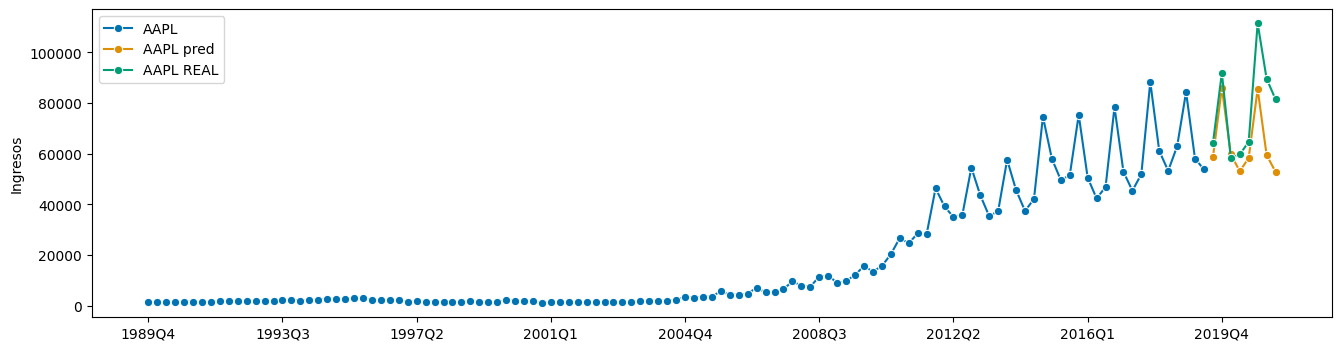

In [9]:
horizon = np.arange(1, 9)
ets_prediction = ets_model.predict(horizon)
ets_intervals = ets_model.predict_interval(horizon, coverage=0.9)
plot_series(y_train, ets_prediction, y_test, labels=["AAPL", "AAPL pred", "AAPL REAL"])

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Ingresos'>)

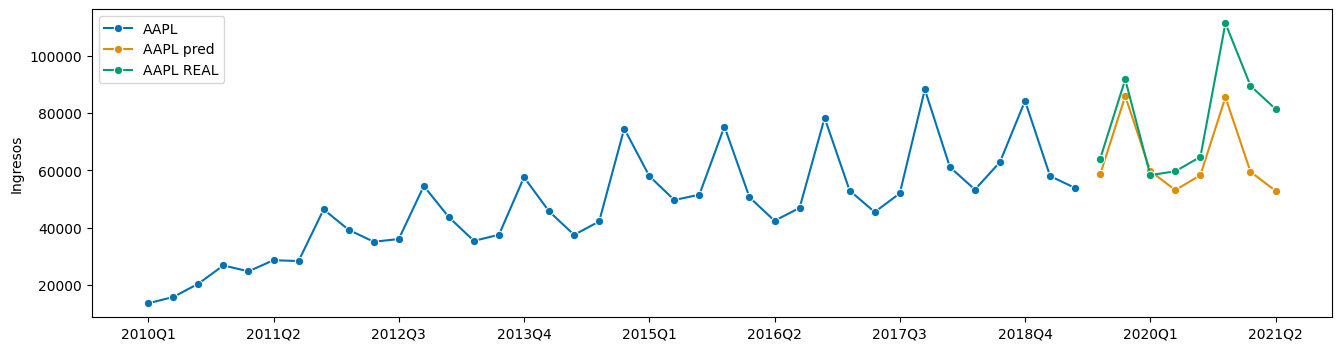

In [10]:
plot_series(y_train['2010':], ets_prediction, y_test, labels=["AAPL", "AAPL pred", "AAPL REAL"])

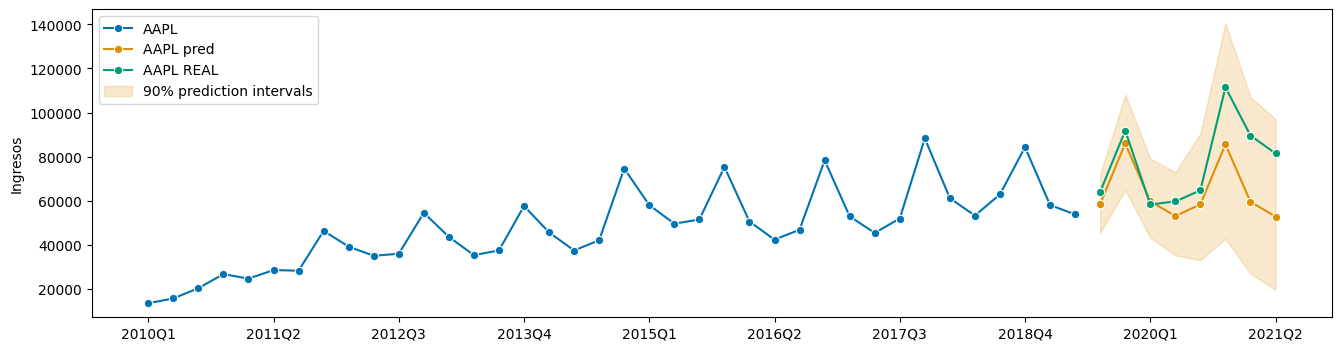

In [11]:
fig, ax = plot_series(y_train['2010':], ets_prediction, y_test, labels=["AAPL", "AAPL pred", "AAPL REAL"])
ax.fill_between(
    ax.get_lines()[-2].get_xdata(),
    ets_intervals[('Ingresos', 0.9, 'lower')],
    ets_intervals[('Ingresos', 0.9, 'upper')],
    alpha=0.2,
    color=ax.get_lines()[-2].get_c(),
    label=f"90% prediction intervals",
)
ax.legend(loc='upper left')


In [12]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
# option 1: using the lean function interface
mean_absolute_percentage_error(y_test, ets_prediction[0:8])

0.16273953082780607

In [13]:
from sktime.performance_metrics.forecasting import MeanSquaredError
mse = MeanSquaredError()
mse(y_test, ets_prediction[0:8])

317747115.49760485

In [14]:
rmse = MeanSquaredError(square_root=True)
rmse(y_test, ets_prediction[0:8])

17825.462560550983

# ARIMA

In [15]:
from sktime.transformations.series.boxcox import LogTransformer

Text(0.5, 1.0, 'Ingresos de Apple Con Transformación Logaritmica')

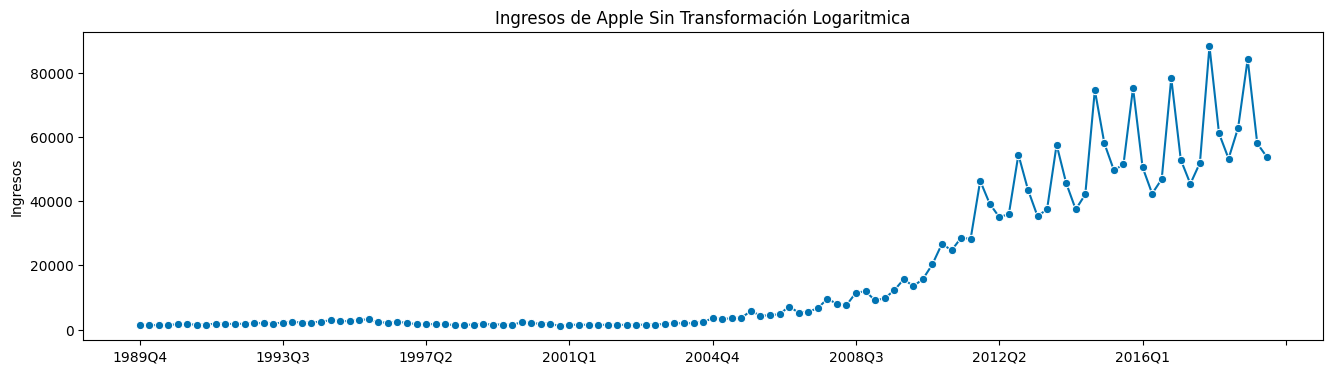

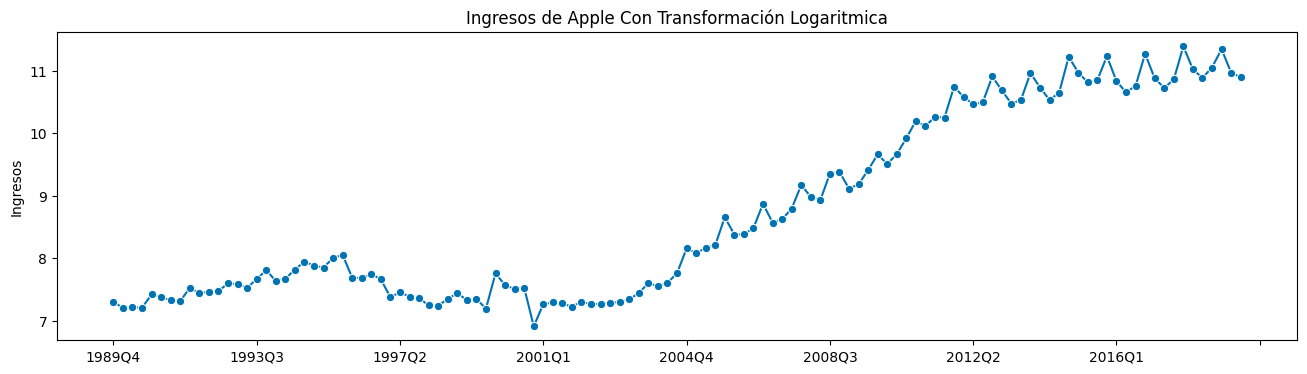

In [16]:
transformer = LogTransformer()
transformer = transformer.fit(y_train)
y_train_log = transformer.transform(y_train)
y_test_log = transformer.transform(y_test)


fig, ax =plot_series(y_train)
ax.set_title('Ingresos de Apple Sin Transformación Logaritmica')
fig, ax =plot_series(y_train_log)
ax.set_title('Ingresos de Apple Con Transformación Logaritmica')

In [17]:
# Autocorrelation Fuction Package
from sktime.utils.plotting import plot_correlations

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='Ingresos'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

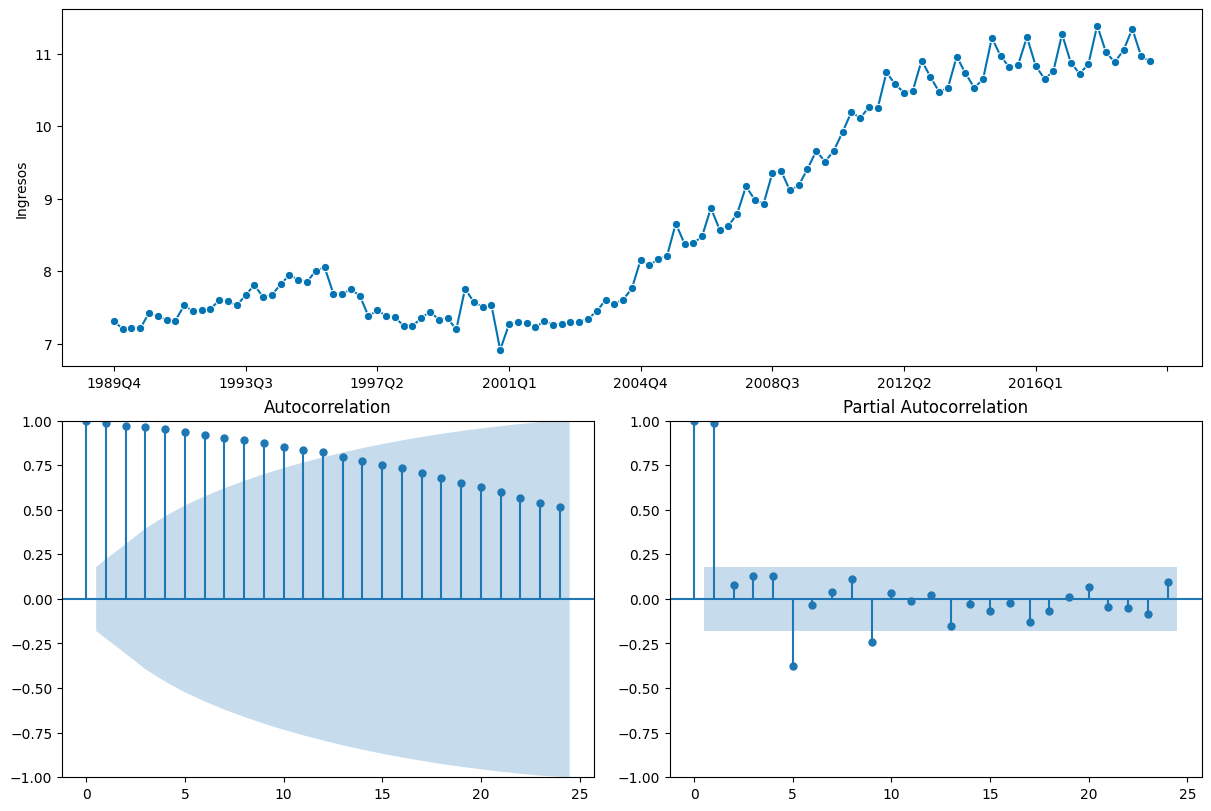

In [18]:
# Autocorrelation Fuction Original Time Series
plot_correlations(y_train_log)

In [19]:
# Difference Fuction Package
from sktime.transformations.series.difference import Differencer

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='Ingresos'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

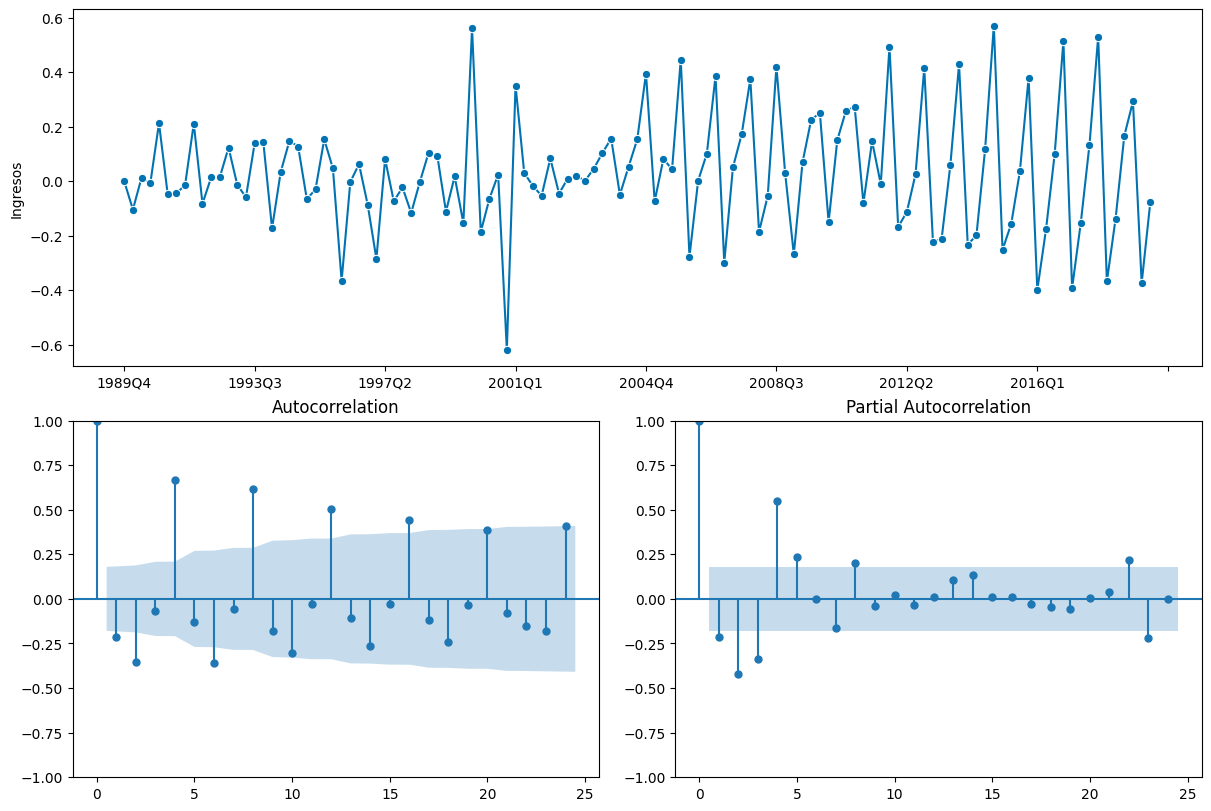

In [20]:
transf_diff=Differencer(lags=[1])
plot_correlations(transf_diff.fit_transform(y_train_log))

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='Ingresos'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

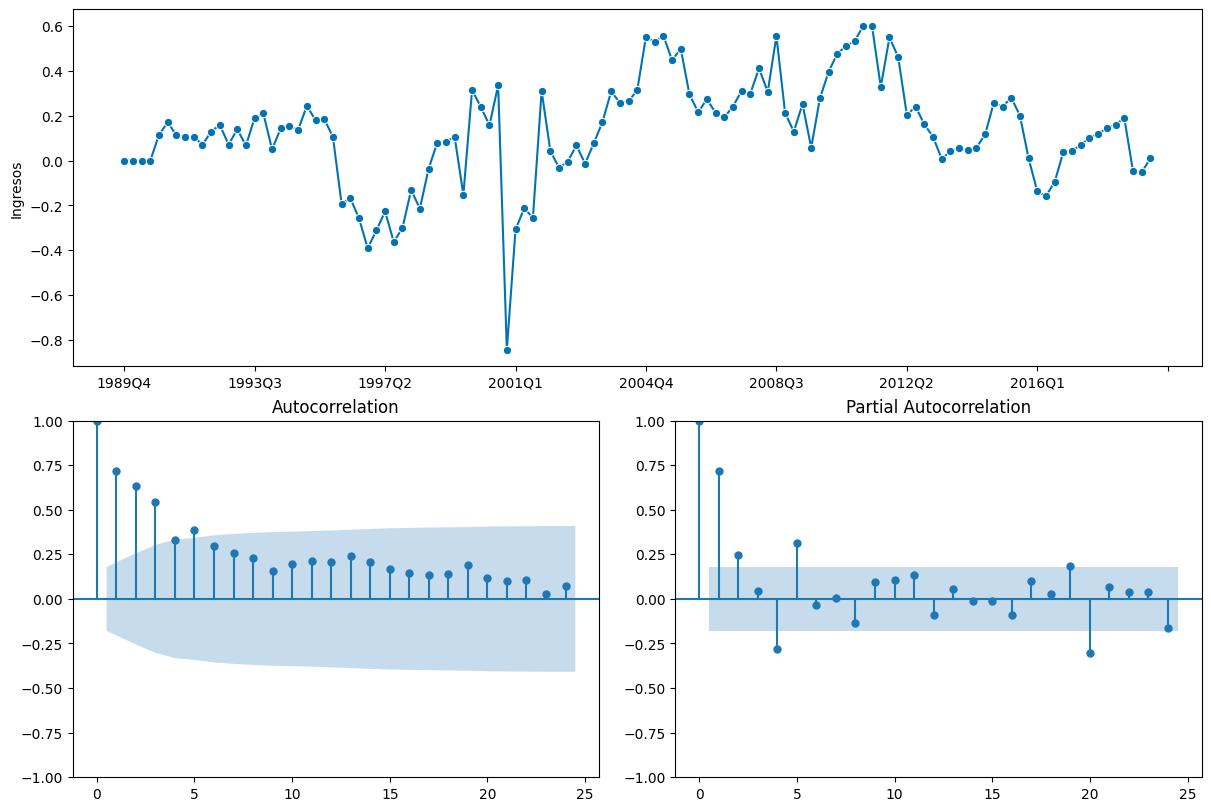

In [21]:
transf_diff=Differencer(lags=[4])
plot_correlations(transf_diff.fit_transform(y_train_log))

In [22]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import AutoARIMA

In [23]:
arima_model = AutoARIMA(sp=4,suppress_warnings=True, trace=True)
arima_model.fit(y_train_log)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=-103.568, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=-19.393, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=-95.407, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=-70.296, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=-19.147, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[4] intercept   : AIC=-89.132, Time=0.34 sec
 ARIMA(2,1,2)(1,0,0)[4] intercept   : AIC=-99.700, Time=0.34 sec
 ARIMA(2,1,2)(2,0,1)[4] intercept   : AIC=-100.914, Time=0.63 sec
 ARIMA(2,1,2)(1,0,2)[4] intercept   : AIC=-101.560, Time=0.51 sec
 ARIMA(2,1,2)(0,0,0)[4] intercept   : AIC=-80.074, Time=0.14 sec
 ARIMA(2,1,2)(0,0,2)[4] intercept   : AIC=-93.801, Time=0.71 sec
 ARIMA(2,1,2)(2,0,0)[4] intercept   : AIC=-100.112, Time=0.54 sec
 ARIMA(2,1,2)(2,0,2)[4] intercept   : AIC=-99.601, Time=0.77 sec
 ARIMA(1,1,2)(1,0,1)[4] intercept   : AIC=-103.218, Time=0.42 sec
 ARIMA(2,1,1)(1,0,1)[4] intercept   : AIC=

AutoARIMA(sp=4, suppress_warnings=True, trace=True)

In [24]:
print(arima_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  119
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 4)   Log Likelihood                  58.362
Date:                           Mon, 09 Oct 2023   AIC                           -108.724
Time:                                   00:27:01   BIC                            -97.642
Sample:                               12-31-1989   HQIC                          -104.224
                                    - 06-30-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3363      0.089     -3.795      0.000      -0.510      -0.163
ar.S.L4        0.9156      0.062     14.822

In [25]:
y_pred_log = arima_model.predict(horizon)
np.exp(y_pred_log)

2019Q3    60183.697665
2019Q4    83757.142309
2020Q1    61525.966307
2020Q2    56094.905297
2020Q3    62284.008682
2020Q4    84294.582636
2021Q1    63554.644381
2021Q2    58398.409676
Freq: Q-DEC, Name: Ingresos, dtype: float64

In [26]:
# Forecast Accuracy
# MAPE
mean_absolute_percentage_error(y_test_log, y_pred_log)

0.013893283182904824

In [27]:
# Forecast Accuracy
# MAPE 
# Orignal Time Serie

mean_absolute_percentage_error(y_test, np.exp(y_pred_log))

0.1396991403642061

In [28]:
# Forecast Accuracy
#Mean Squared Error
rmse = MeanSquaredError(square_root=True)
rmse(y_test_log, y_pred_log)

0.2021142944818101

In [29]:
# Forecast Accuracy
#Mean Squared Error
rmse = MeanSquaredError(square_root=True)
rmse(y_test, np.exp(y_pred_log))

16022.987678740737

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Ingresos'>)

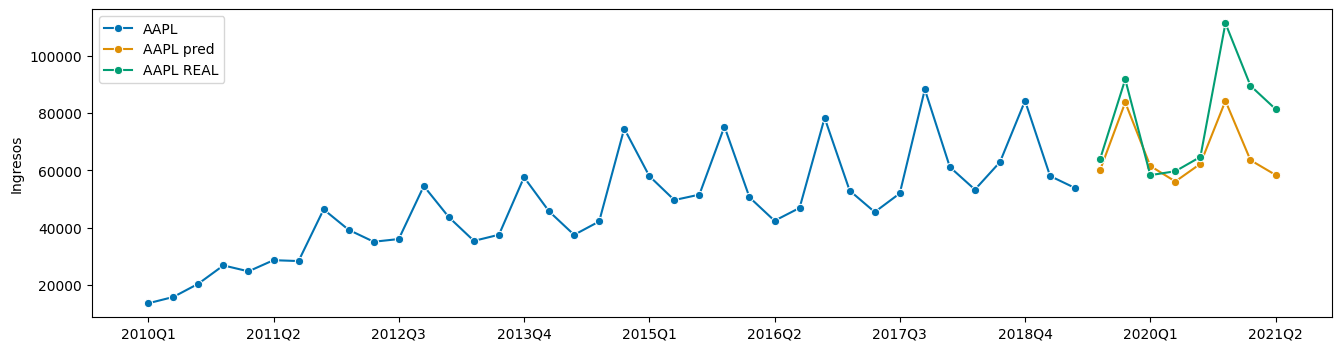

In [30]:
# Forecast Accuracy Plot
# Plotting predictions and past data
plot_series(y_train['2010':], np.exp(y_pred_log),y_test, labels=["AAPL", "AAPL pred", "AAPL REAL"])

# Estimacion final

In [31]:
horizon = np.arange(10)
historic = df['Ingresos'].astype('float64').to_period('Q')

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Ingresos'>)

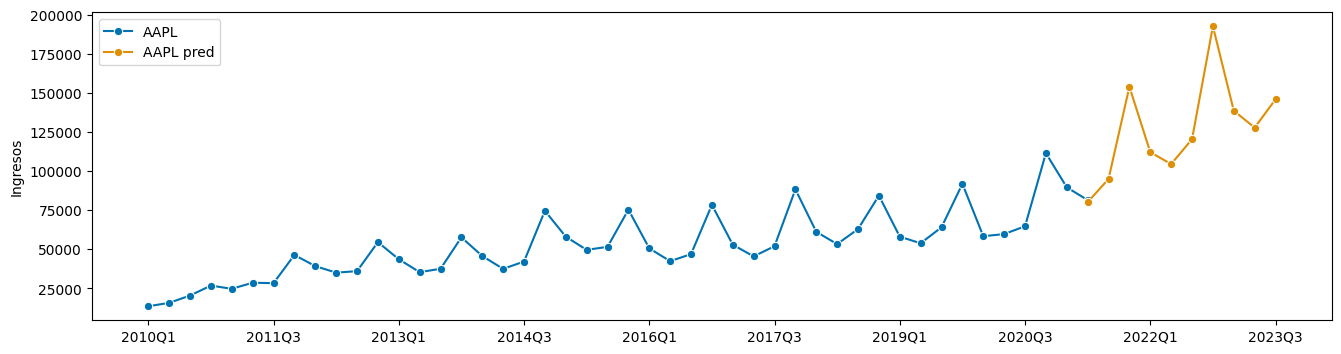

In [32]:
final_ets_model = AutoETS(auto=True, sp=4, n_jobs=-1)
final_ets_model.fit(historic)
ets_pred = final_ets_model.predict(horizon)
plot_series(historic['2010':], ets_pred, labels=["AAPL", "AAPL pred"])


In [33]:
historic_log = LogTransformer().fit_transform(historic)
final_arima_model = AutoARIMA(sp=4,suppress_warnings=True)
final_arima_model.fit(historic_log)
arima_pred = final_arima_model.predict(horizon)
np.exp(arima_pred)

2021Q2     79455.482038
2021Q3     89895.945766
2021Q4    134667.234168
2022Q1    102009.858613
2022Q2     95842.491950
2022Q3    105437.409904
2022Q4    153159.630063
2023Q1    118223.982521
2023Q2    111563.084228
2023Q3    121951.441015
Freq: Q-DEC, Name: Ingresos, dtype: float64

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Ingresos'>)

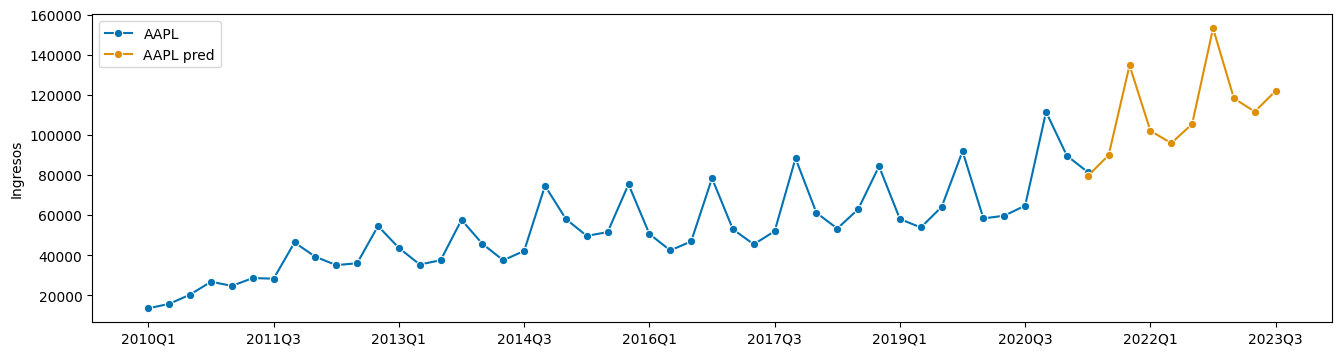

In [34]:
plot_series(historic['2010':], np.exp(arima_pred), labels=["AAPL", "AAPL pred"])

# Preguntas a resolver

- ¿Los ingresos de Apple son estacionarios? ¿En media? ¿En varianza?

In [35]:
"""
No, no hay estacionariedad. Tanto la media como la varianza son no estacionarias
"""

'\nNo, no hay estacionariedad. Tanto la media como la varianza son no estacionarias\n'

- ¿Cuál es su tendencia? ¿y su componente estacional?

In [36]:
"""
Tendecia aditiva, y estacionalidad multiplicativa. Aunque tambien se podria decir que la tendencia es multiplicativa en los ultimos periodos
"""

'\nTendecia aditiva, y estacionalidad multiplicativa. Aunque tambien se podria decir que la tendencia es multiplicativa en los ultimos periodos\n'

- ¿Cuales son las ventas anuales de Apple?

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Ingresos'>)

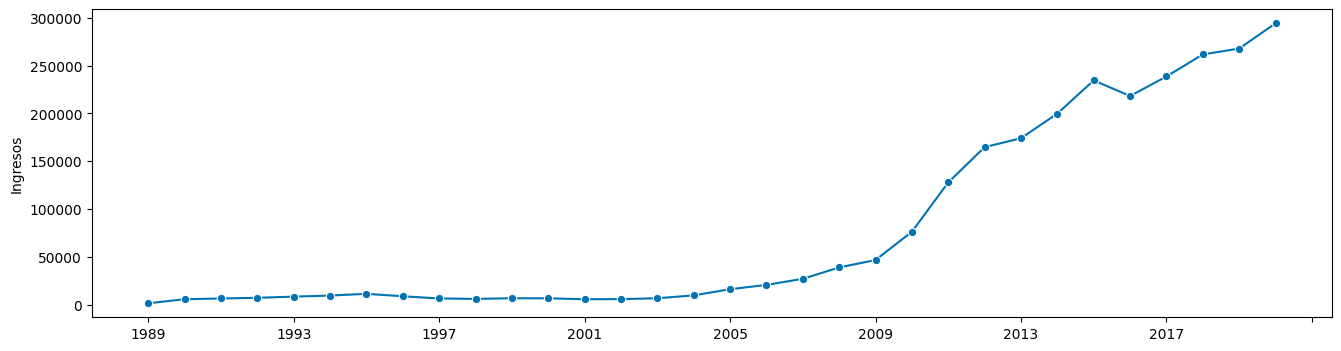

In [42]:
anual = df[:'2020']['Ingresos'].groupby(pd.Grouper(freq='Y')).sum()
anual.index = anual.index.year

plot_series(anual)

- ¿Cuales son los crecimientos anuales de los ingresos?

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Ingresos'>)

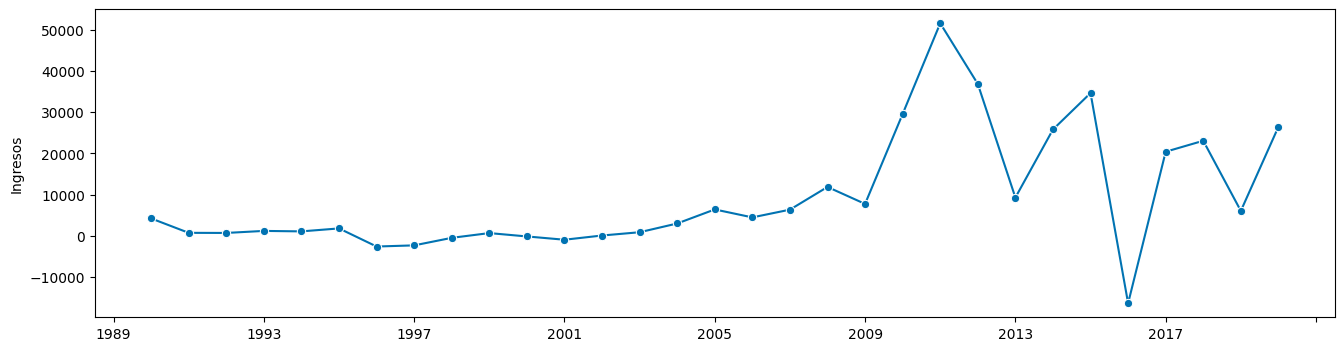

In [45]:
plot_series(anual.diff())

- ¿Qué modelo predice mejor?

In [ ]:
"""
Ambos dan resultados muy parecidos, pero el ARIMA parece ser ligeramente mas preciso cuando se mide los errores porcentuales
"""

- ¿Existe efecto COVID? Cuantificar

In [ ]:
"""
No parece haber un gran efecto del COVID en serie de temporal de ingresos de Apple. 
El comportamiento de las ventas fue muy parecido a lo que se podría haber predicho meses antes de los cierres por cuarentena.
"""

- ¿Cuales son las ventas acumuladas para el año 2021? ¿Y para el 2022?

In [210]:
print(
    f"Ventas 2021 por metodo ETS: {round((historic['2021':'2021'].sum() + ets_pred['2021':'2021'][1:].sum())/1000, 2)}",
    f"\nVentas 2021 por metodo Arima: {round((historic['2021':'2021'].sum() + np.exp(arima_pred)['2021':'2021'][1:].sum())/1000, 2)}",
    f"\nVentas 2022 por metodo ETS: {round(ets_pred['2022':'2022'].sum()/1000, 2)}",
    f"\nVentas 2022 por metodo Arima: {round(np.exp(arima_pred)['2022':'2022'].sum()/1000, 2)}",
    
)

Ventas 2021 por metodo ETS: 419.85 
Ventas 2021 por metodo Arima: 395.58 
Ventas 2022 por metodo ETS: 529.53 
Ventas 2022 por metodo Arima: 456.45


- ¿Son creíbles las predicciones del Barclays?

In [ ]:
"""
Teniendo en cuenta que Barclays predice: 368.9 en 2021 y 378.6 en 2022, las predicciones parecen algo más razonables en 2021 pero muy distantes en 2022.
En el primer año, el diferencial de predicción entre Barclays y los modelos no llega al 10%, pero el segundo año se acerca al 20%, una cantidad ciertamente elevada.
"""